## 합성곱 신경망

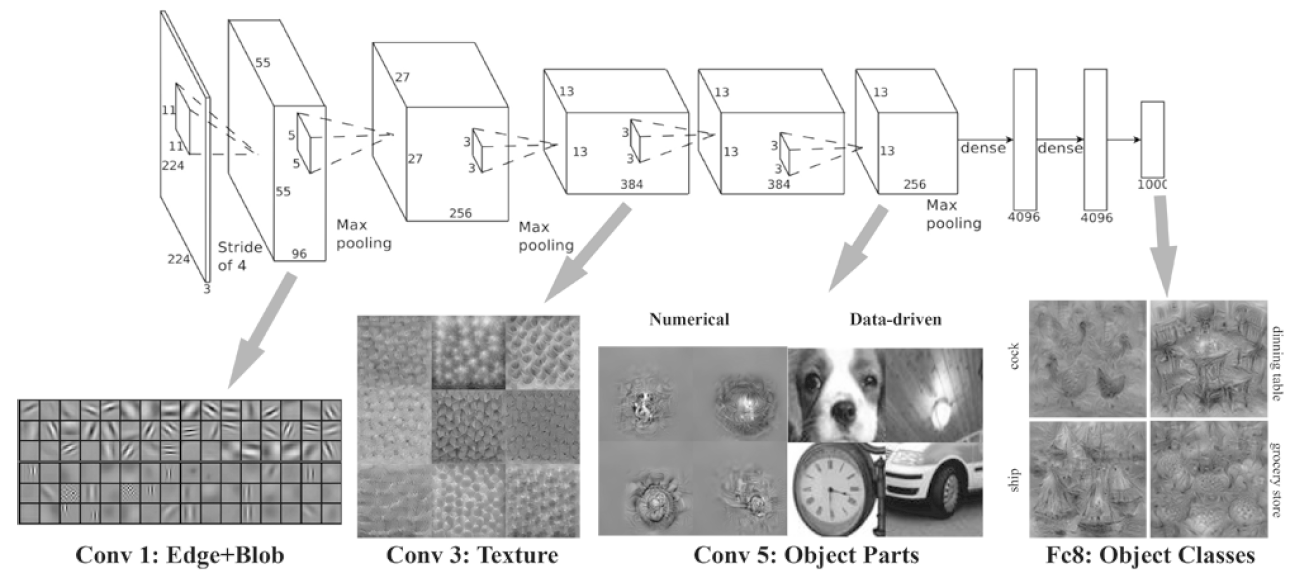

CNN에서는 새로운 합성곱 계층과 풀링 계층이 추가된다. CNN 계층은 conc-relu-pooling 흐름으로 연결된다. 여기서 중요한 것은 출력에 가까운 층에서는 affine-relu 구성을 사용할 수 있다.

In [1]:
#4차원 배열

import numpy as np
x=np.random.rand(10, 1, 28, 28)
x.shape
x[0].shape
x[1].shape
x[0,0] # 첫번째 데이터의 첫 채널의 공간 데이터

array([[0.17036559, 0.92482705, 0.31562142, 0.08427477, 0.33107497,
        0.92448462, 0.64732738, 0.52454497, 0.82057782, 0.41165632,
        0.10863839, 0.5644636 , 0.79884735, 0.71249462, 0.53388476,
        0.00200149, 0.42375278, 0.81114768, 0.2404106 , 0.23921383,
        0.41772754, 0.12066845, 0.69479242, 0.69490969, 0.84195449,
        0.54319035, 0.98233684, 0.77408018],
       [0.64842339, 0.93124169, 0.54120894, 0.19748169, 0.76068015,
        0.46280975, 0.40722606, 0.38900348, 0.83535933, 0.657138  ,
        0.5549135 , 0.23153323, 0.73984355, 0.57889802, 0.14693436,
        0.55244569, 0.01135375, 0.33316261, 0.66222727, 0.99813666,
        0.95205321, 0.30956765, 0.81003627, 0.47354959, 0.3360194 ,
        0.03490104, 0.9359659 , 0.26607491],
       [0.02249364, 0.22790702, 0.7284554 , 0.89626814, 0.12597253,
        0.62841479, 0.68878467, 0.67769862, 0.6521641 , 0.11174104,
        0.26804704, 0.69470827, 0.20169127, 0.69300998, 0.49234016,
        0.75049232, 0.0281

## im2col로 데이터 전개하기
넘파이에 for 문을 사용하면 성능이 떨어지기 때문에 im2col이라는 편의 함수를 이용해본다. im2col은 입력 데이터를 필터링하기 좋게 전개하는 함수이다.

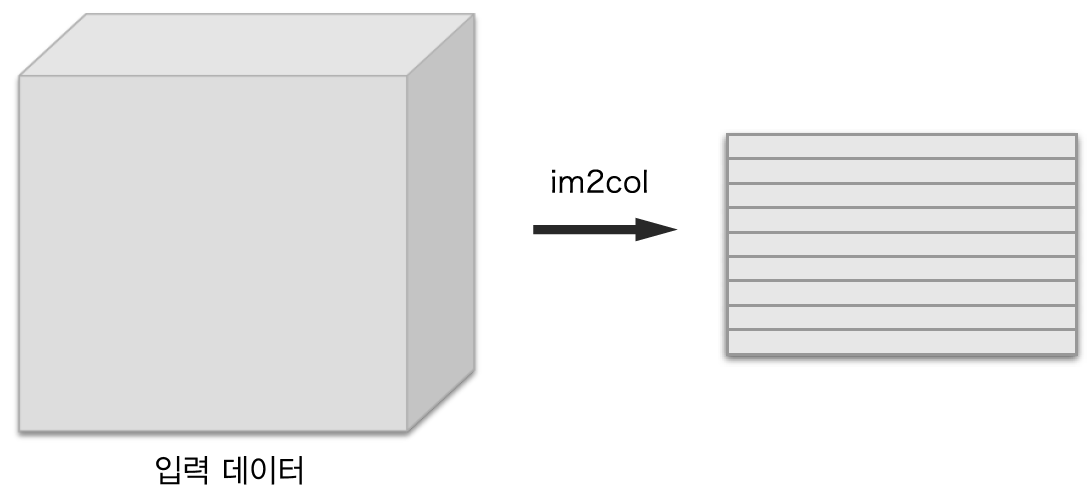

In [2]:
import numpy as np

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    print(f"입력 데이터의 크기: (이미지 수 N={N}, 채널 수 C={C}, 높이 H={H}, 너비 W={W})")
    
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    print(f"출력 크기: (높이 out_h={out_h}, 너비 out_w={out_w})")
    
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    print(f"패딩 후 이미지 크기: {img.shape}")
    
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    print("필터 적용 후 배열 크기:", col.shape)

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            print(f"필터 (y={y}, x={x}) 적용: y_max={y_max}, x_max={x_max}")
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    print("최종 변환된 2차원 배열 크기:", col.shape)
    return col


In [3]:
# 예시 입력 데이터 (1개의 이미지, 3개의 채널, 높이 5, 너비 5)
input_data = np.random.rand(1, 3, 5, 5)

# 필터 크기 3x3, 스트라이드 1, 패딩 0
filter_h = 3
filter_w = 3
stride = 1
pad = 0

# im2col 함수 호출
col = im2col(input_data, filter_h, filter_w, stride, pad)


입력 데이터의 크기: (이미지 수 N=1, 채널 수 C=3, 높이 H=5, 너비 W=5)
출력 크기: (높이 out_h=3, 너비 out_w=3)
패딩 후 이미지 크기: (1, 3, 5, 5)
필터 적용 후 배열 크기: (1, 3, 3, 3, 3, 3)
필터 (y=0, x=0) 적용: y_max=3, x_max=3
필터 (y=0, x=1) 적용: y_max=3, x_max=4
필터 (y=0, x=2) 적용: y_max=3, x_max=5
필터 (y=1, x=0) 적용: y_max=4, x_max=3
필터 (y=1, x=1) 적용: y_max=4, x_max=4
필터 (y=1, x=2) 적용: y_max=4, x_max=5
필터 (y=2, x=0) 적용: y_max=5, x_max=3
필터 (y=2, x=1) 적용: y_max=5, x_max=4
필터 (y=2, x=2) 적용: y_max=5, x_max=5
최종 변환된 2차원 배열 크기: (9, 27)


In [5]:
im2col(np.random.rand(1,3,7,7),5,5,stride=1,pad=0)

입력 데이터의 크기: (이미지 수 N=1, 채널 수 C=3, 높이 H=7, 너비 W=7)
출력 크기: (높이 out_h=3, 너비 out_w=3)
패딩 후 이미지 크기: (1, 3, 7, 7)
필터 적용 후 배열 크기: (1, 3, 5, 5, 3, 3)
필터 (y=0, x=0) 적용: y_max=3, x_max=3
필터 (y=0, x=1) 적용: y_max=3, x_max=4
필터 (y=0, x=2) 적용: y_max=3, x_max=5
필터 (y=0, x=3) 적용: y_max=3, x_max=6
필터 (y=0, x=4) 적용: y_max=3, x_max=7
필터 (y=1, x=0) 적용: y_max=4, x_max=3
필터 (y=1, x=1) 적용: y_max=4, x_max=4
필터 (y=1, x=2) 적용: y_max=4, x_max=5
필터 (y=1, x=3) 적용: y_max=4, x_max=6
필터 (y=1, x=4) 적용: y_max=4, x_max=7
필터 (y=2, x=0) 적용: y_max=5, x_max=3
필터 (y=2, x=1) 적용: y_max=5, x_max=4
필터 (y=2, x=2) 적용: y_max=5, x_max=5
필터 (y=2, x=3) 적용: y_max=5, x_max=6
필터 (y=2, x=4) 적용: y_max=5, x_max=7
필터 (y=3, x=0) 적용: y_max=6, x_max=3
필터 (y=3, x=1) 적용: y_max=6, x_max=4
필터 (y=3, x=2) 적용: y_max=6, x_max=5
필터 (y=3, x=3) 적용: y_max=6, x_max=6
필터 (y=3, x=4) 적용: y_max=6, x_max=7
필터 (y=4, x=0) 적용: y_max=7, x_max=3
필터 (y=4, x=1) 적용: y_max=7, x_max=4
필터 (y=4, x=2) 적용: y_max=7, x_max=5
필터 (y=4, x=3) 적용: y_max=7, x_max=6
필터 (y=4, x=4) 적용: 

array([[0.11937525, 0.73027973, 0.17182633, 0.59321256, 0.21829825,
        0.54671102, 0.71813513, 0.25011097, 0.29222717, 0.23773502,
        0.08263879, 0.17483901, 0.67959885, 0.9711385 , 0.44312026,
        0.43512202, 0.94713898, 0.82534092, 0.61579023, 0.62348209,
        0.43180238, 0.97216169, 0.91301082, 0.56849343, 0.43617137,
        0.51347475, 0.56787553, 0.41970691, 0.62192243, 0.59914571,
        0.69989482, 0.54786847, 0.01349674, 0.69810141, 0.91624396,
        0.35097253, 0.95821362, 0.59329468, 0.04876929, 0.17248795,
        0.74379605, 0.69599893, 0.09267879, 0.36692194, 0.30471986,
        0.68367188, 0.54241028, 0.13965542, 0.79158364, 0.89166928,
        0.79896687, 0.17500652, 0.60151599, 0.68731044, 0.36960891,
        0.22323772, 0.91529017, 0.23457056, 0.56868811, 0.45956376,
        0.39951069, 0.46877315, 0.4097083 , 0.65703079, 0.07961909,
        0.73048593, 0.55749684, 0.00720238, 0.98498296, 0.04106915,
        0.53448495, 0.37856243, 0.13559054, 0.07

In [6]:
class Convolution:
    def __inti__(self, w, b, stride=1, pad=0):
        self.w=w
        self.b=b
        self.stride=stride
        self.pad
    
    def forward(self, x):
        fn, c, fh, fw=self.w.shape
        n,c,h,w=x.shape
        out_h=int(1+(h+2*self.pad-fh)/self.stride)
        out_w=int(1+(w+2*self.pad-fw)/self.stride)
        
        col=im2col(x, fh, fw, self.stride, self.pad)
        col_w=self.w.reshape(fn, -1).T
        out=np.dot(col,col_w)+self.b
        
        out=out.reshpae(n, out_h, out_w, -1).transpose(0,3,1,2)
        
        return out

## 풀링 계층 구현하기

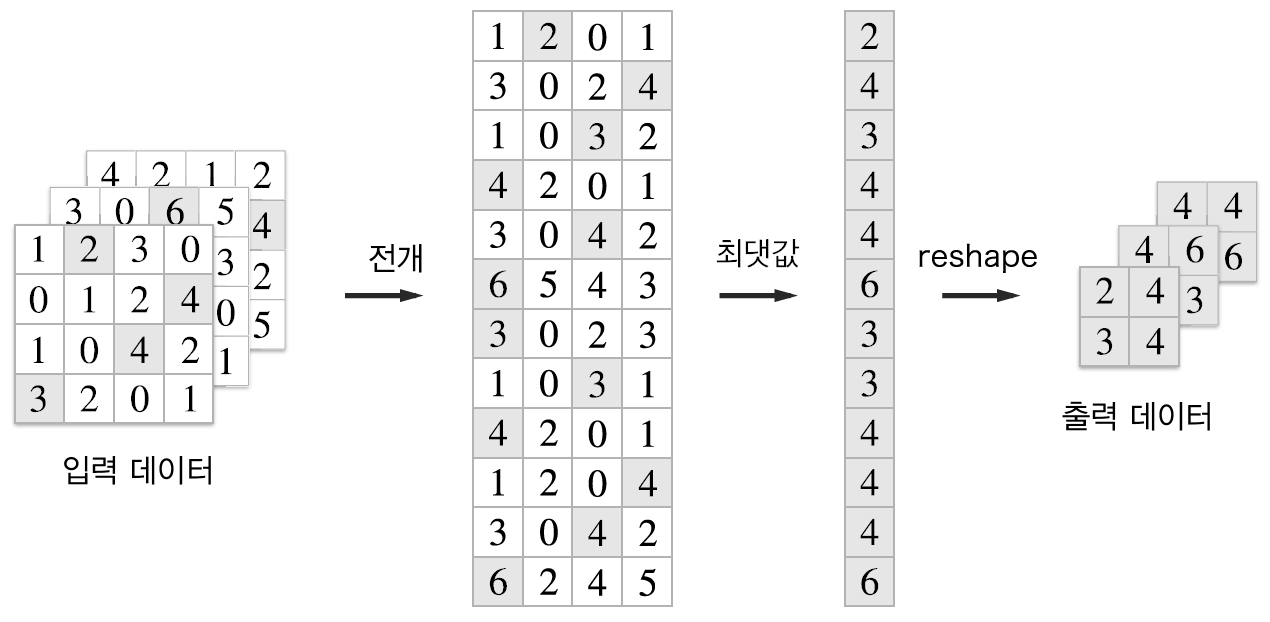

In [7]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h=pool_h
        self.pool_w=pool_w
        self.stride=stride
        self.pad=pad
        
    def forward(self, x):
        n, c, h, w=x.shape
        out_h=int(1+(h-self.pool_h)/self.stride)
        out_w=int(1+(w-self.pool_w)/self.stride)
        
        col=im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)  #전개
        col=col.reshape(-1, self.pool_h*self.pool_w)
        
        out=np.max(col, axis=1) #최댓값
        
        out=out.reshape(n, out_h, out_w, c).transpose(0, 3, 1, 2)
        
        return out

## CNN구현하기

In [10]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


train loss:2.2991387002141566
=== epoch:1, train acc:0.255, test acc:0.209 ===
train loss:2.295170181696254
train loss:2.291746695740261
train loss:2.2810117367505987
train loss:2.27656791218549
train loss:2.252022005915551
train loss:2.2454195066018263
train loss:2.235173097109322
train loss:2.231488102189076
train loss:2.1673799820674766
train loss:2.1360520576040924
train loss:2.1275634902708505
train loss:2.0729028807495125
train loss:2.0731680249265394
train loss:2.0813127557608295
train loss:2.0034659842436016
train loss:1.9233787165554717
train loss:1.8940098217995416
train loss:1.767430026476579
train loss:1.6954627075747015
train loss:1.6185140830449751
train loss:1.5599768795436875
train loss:1.4550449941422834
train loss:1.4229850405060136
train loss:1.4087531518937673
train loss:1.1977591484843433
train loss:1.2335205953680326
train loss:1.2492726090952755
train loss:1.1340130427563802
train loss:0.9783602887093704
train loss:0.8440219641506818
train loss:1.0394217498230522

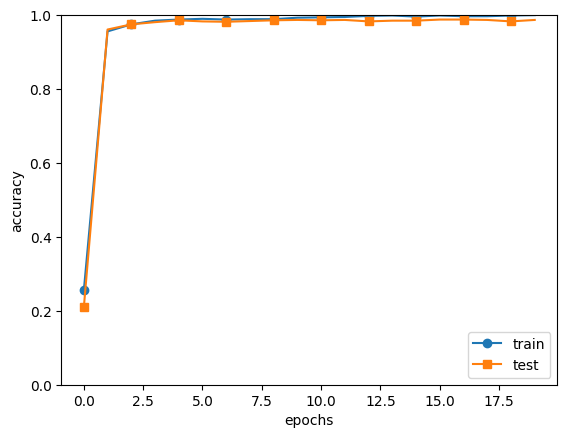

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


## CNN 시각화하기

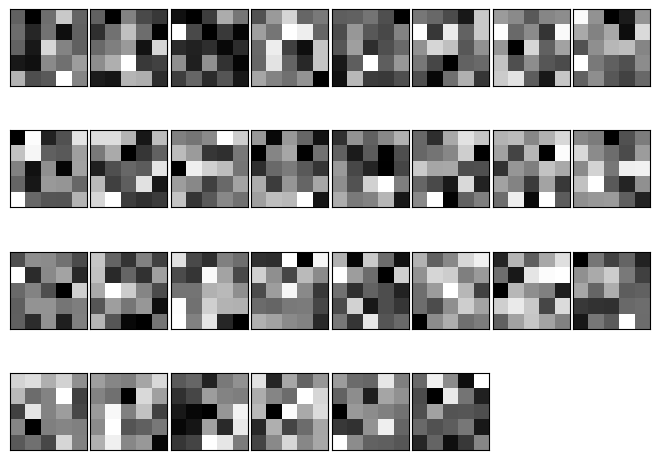

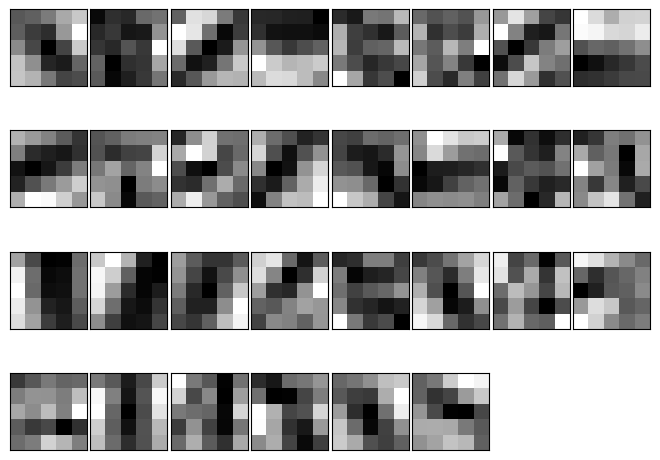

In [15]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])





In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 고속화를 위한 표본추출
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16(반정밀도)로 형변환
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))


In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)
    
acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()
 
max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])
            
        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()


In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from deep_convnet import DeepConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")
